In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import zarr
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


**MODELS**

In [3]:
from src.models.encoders import models

**All Files Loading Info**


In [ ]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path(".").resolve().parent
data_path = project_root / "data" / "processed"
models_path = project_root / "models"
embeddings_path = project_root / "embeddings"

print("Project root:", project_root)
print("Data path:", data_path)
print("Models path:", models_path)
print("Embeddings path:", embeddings_path)

Project root: /home/ubuntu/semrep
Data path: /home/ubuntu/semrep/data/processed
Models path: /home/ubuntu/semrep/models
Embeddings path: /home/ubuntu/semrep/embeddings


In [5]:
# Load the data
sim2 = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]
sim2_labels = sim2["action/pos"]
real_labels = real["action/pos"]


print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 50 trajectories containing 24131 frames
Loaded 50 trajectories containing 27699 frames


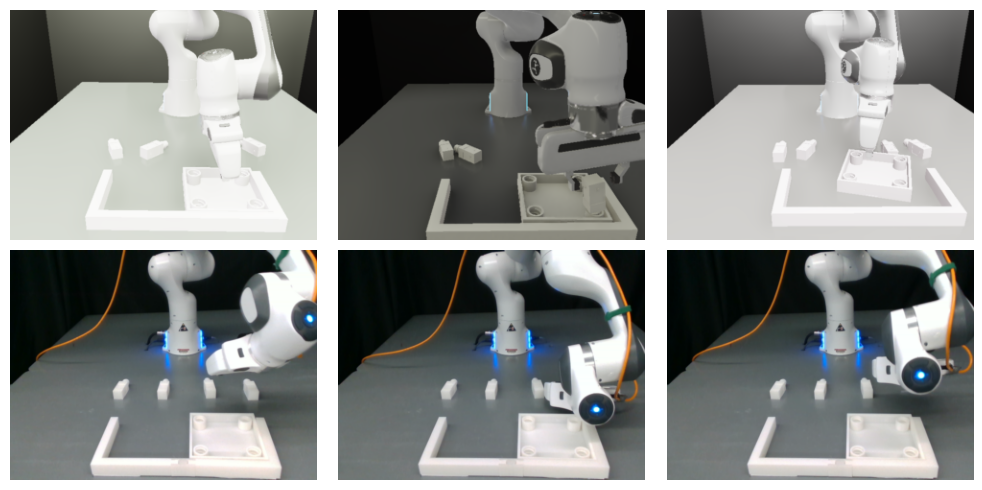

In [6]:
# Sample 8 images from each dataset
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=3, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=3, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for i, idx in enumerate(sim2_indices):
    axes[1 - 1, i].imshow(sim2_imgs[idx])
    axes[1 - 1, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[2 - 1, i].imshow(real_imgs[idx])
    axes[2 - 1, i].axis("off")

plt.tight_layout()
plt.show()

**TSNE**


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from src.models.tsne import plot_tsne

# Directory containing the embedding files
embeddings_dir = Path("/home/ubuntu/semrep/embeddings/encoders")
# Directory to save the plots
output_dir = Path("/home/ubuntu/semrep/src/models/images")

# Number of samples to use for t-SNE
n_samples = 5000

# Iterate through all .npz files in the directory
for file_path in embeddings_dir.glob("*.npz"):
    try:
        # Extract model name from filename (without .npz extension)
        model_name = file_path.stem
        
        # Create model-specific subdirectory
        model_output_dir = output_dir / model_name
        model_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Load the dataset
        dataset = np.load(file_path)
        
        # Sample a subset of the data
        indices = np.random.choice(len(dataset["embeddings"]), n_samples, replace=False)
        
        embeddings = dataset["embeddings"][indices]
        domain_labels = dataset["dataset_flag"][indices]
        
        # Perform t-SNE
        simembeddings, realembeddings = plot_tsne(embeddings, domain_labels)
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        plt.scatter(
            simembeddings[:, 0], simembeddings[:, 1], c="orange", label="Sim", alpha=0.7
        )
        plt.scatter(
            realembeddings[:, 0], realembeddings[:, 1], c="blue", label="Real", alpha=0.7
        )
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend()
        plt.title(f"t-SNE visualization of sim vs real embeddings - {model_name}")
        
        # Save the plot
        output_path = model_output_dir / f"{model_name}_tsne.png"
        plt.savefig(output_path)
        plt.close()  # Close the figure to free up memory
        
        print(f"Saved t-SNE plot for {model_name} to {output_path}")
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

Saved t-SNE plot for vgg19 to /home/ubuntu/semrep/src/models/images/vgg19/vgg19_tsne.png
Saved t-SNE plot for EfficientNetB0 to /home/ubuntu/semrep/src/models/images/EfficientNetB0/EfficientNetB0_tsne.png
Saved t-SNE plot for ResNet18 to /home/ubuntu/semrep/src/models/images/ResNet18/ResNet18_tsne.png
Saved t-SNE plot for ViT to /home/ubuntu/semrep/src/models/images/ViT/ViT_tsne.png
Saved t-SNE plot for R3M18 to /home/ubuntu/semrep/src/models/images/R3M18/R3M18_tsne.png
Saved t-SNE plot for Swin to /home/ubuntu/semrep/src/models/images/Swin/Swin_tsne.png
Saved t-SNE plot for HRP-ViT to /home/ubuntu/semrep/src/models/images/HRP-ViT/HRP-ViT_tsne.png
Saved t-SNE plot for CLIP-Base-16 to /home/ubuntu/semrep/src/models/images/CLIP-Base-16/CLIP-Base-16_tsne.png
Saved t-SNE plot for R3M50 to /home/ubuntu/semrep/src/models/images/R3M50/R3M50_tsne.png
Saved t-SNE plot for CLIP-Base-32 to /home/ubuntu/semrep/src/models/images/CLIP-Base-32/CLIP-Base-32_tsne.png
Saved t-SNE plot for MCR to /home/u

**GradCAM**

In [44]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
from src.models.gradcam_module import prepare_image


def visualize_gradcam(model, raw_image, device="cuda"):
    """
    Generate and display GradCAM visualization for a given model and image

    Args:
        model: The model to analyze
        raw_image: Input image as numpy array
        device: Device to run model on (default: "cuda")
    """
    processed_image = prepare_image(raw_image, device=device)
    print(processed_image.shape)
    target_layers = model.get_gradcam_target_layers()
    transform = model.get_gradcam_transform()

    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=transform)
    grayscale_cam = cam(input_tensor=processed_image)

    # Resize raw_image to match GradCAM output (224, 224)
    raw_image_resized: Image.Image = transforms.Compose(
        [transforms.ToPILImage(), transforms.Resize((224, 224))]
    )(raw_image).convert("RGB")

    # Convert raw_image_resized to numpy for overlay
    raw_image_resized = np.asarray(raw_image_resized) / 255.0

    visualization = show_cam_on_image(raw_image_resized, grayscale_cam[0, :], use_rgb=True)

    return visualization

def plot_gradcam_visualizations(sim_images, real_images, models, sim_indices, real_indices):
    """
    Plot GradCAM visualizations in a 2x4 grid for each model, with simulation and real images side-by-side

    Args:
        sim_images: Simulation dataset
        real_images: Real dataset
        models: Dictionary of models to analyze
        sim_indices: Indices for simulation images
        real_indices: Indices for real images
    """
    # Output directory for images
    output_base_dir = "/home/ubuntu/semrep/src/models/images"

    for i, (model_name, model_fn) in enumerate(models.items()):
        model = model_fn()

        # Create model-specific output directory
        model_output_dir = os.path.join(output_base_dir, model_name)
        os.makedirs(model_output_dir, exist_ok=True)

        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        

        # Simulation images (first row)
        for j, image_index in enumerate(sim_indices):
            try:
                raw_image = sim_images[image_index]
                gradcam_viz = visualize_gradcam(model, raw_image, device='cuda')
                axes[0, j].imshow(gradcam_viz)
                axes[0, j].set_title(f'Sim Index: {image_index}')
                axes[0, j].axis('off')
            except Exception as e:
                print(f"Error processing {model_name} for sim image {image_index}: {e}")
                axes[0, j].text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
                axes[0, j].axis('off')

        # Real images (second row)
        for j, image_index in enumerate(real_indices):
            try:
                raw_image = real_images[image_index]
                gradcam_viz = visualize_gradcam(model, raw_image, device='cuda')
                axes[1, j].imshow(gradcam_viz)
                axes[1, j].set_title(f'Real Index: {image_index}')
                axes[1, j].axis('off')
            except Exception as e:
                print(f"Error processing {model_name} for real image {image_index}: {e}")
                axes[1, j].text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
                axes[1, j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the plot
        plot_path = os.path.join(model_output_dir, f"gradcam_visualization.png")
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved GradCAM plot for {model_name} to {plot_path}")

sim_indices = [0, 100, 4835, 3667]
real_indices = [21,119, 3325, 2200]

# Call the plotting function
plot_gradcam_visualizations(sim2_imgs, real_imgs, models, sim_indices, real_indices)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for ResNet18 to /home/ubuntu/semrep/src/models/images/ResNet18/gradcam_visualization.png
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for ResNet34 to /home/ubuntu/semrep/src/models/images/ResNet34/gradcam_visualization.png
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for ResNet50 to /home/ubuntu/semrep/src/models/images/ResNet50/gradca

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for Swin to /home/ubuntu/semrep/src/models/images/Swin/gradcam_visualization.png


/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/vip/__init__.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for VIP to /home/ubuntu/semrep/src/models/images/VIP/gradcam_visualization.png


/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  r3m_state_dict = remove_language_head(torch.lo

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for R3M18 to /home/ubuntu/semrep/src/models/images/R3M18/gradcam_visualization.png
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for R3M34 to /home/ubuntu/semrep/src/models/images/R3M34/gradcam_visualization.png
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for R3M50 to /home/ubuntu/semrep/src/models/images/R3M50/gradcam_visualization.pn

/home/ubuntu/eai-vc/vc_models/src/vc_models/models/vit/vit.py:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cpu")

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for VC1-B to /home/ubuntu/semrep/src/models/images/VC1-B/gradcam_visualization.png
Data already downloaded!
Restoring model from /home/ubuntu/data4robotics/data4robotics/../visual_features/resnet18/IN_1M_resnet18.pth


/home/ubuntu/data4robotics/data4robotics/models/base.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(restore_path, map_location='cpu')


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for HRP-ResNet18 to /home/ubuntu/semrep/src/models/images/HRP-ResNet18/gradcam_visualization.png
Data already downloaded!
Restoring model from /home/ubuntu/data4robotics/data4robotics/../visual_features/vit_base/SOUP_1M_DH.pth


/home/ubuntu/data4robotics/data4robotics/models/vit.py:227: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(restore_path, map_location='cpu')


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for HRP-ViT to /home/ubuntu/semrep/src/models/images/HRP-ViT/gradcam_visualization.png
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for CLIP-Base-16 to /home/ubuntu/semrep/src/models/images/CLIP-Base-16/gradcam_visualization.png
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for CLIP-Base-32 to /home/ubuntu/semrep/src/models/images/CLIP-

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/mvp/backbones/vit.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f, map_location=

Loaded encoder from: /tmp/mvp-download-cache/vitb-mae-egosoup.pth
torch.Size([1, 3, 224, 224])
Error processing MVP for sim image 0: 'NoneType' object has no attribute 'shape'
torch.Size([1, 3, 224, 224])
Error processing MVP for sim image 100: 'NoneType' object has no attribute 'shape'
torch.Size([1, 3, 224, 224])
Error processing MVP for sim image 4835: 'NoneType' object has no attribute 'shape'
torch.Size([1, 3, 224, 224])
Error processing MVP for sim image 3667: 'NoneType' object has no attribute 'shape'
torch.Size([1, 3, 224, 224])
Error processing MVP for real image 21: 'NoneType' object has no attribute 'shape'
torch.Size([1, 3, 224, 224])
Error processing MVP for real image 119: 'NoneType' object has no attribute 'shape'
torch.Size([1, 3, 224, 224])
Error processing MVP for real image 3325: 'NoneType' object has no attribute 'shape'
torch.Size([1, 3, 224, 224])
Error processing MVP for real image 2200: 'NoneType' object has no attribute 'shape'
Saved GradCAM plot for MVP to /ho

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Saved GradCAM plot for DinoV2-B to /home/ubuntu/semrep/src/models/images/DinoV2-B/gradcam_visualization.png


**Action Probing**

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from src.models.actionprobe import train_action_probe
from src.models.loadsplit import load_and_use_existing_split

training_configs = [
    {"batch_size": 200, "epochs": 100, "lr": 0.01, "config_name": "small"},
    {"batch_size": 1000, "epochs": 100, "lr": 0.01, "config_name": "regular"},
    {"batch_size": 1000, "epochs": 10000, "lr": 0.01, "config_name": "main"}
]


def run_action_probe_for_models(models, embeddings_path):
    for model_name, model_fn in models.items():
        print(f"Running action probe for model: {model_name}")

        file_path = embeddings_path / f"encoders/{model_name}.npz"

        output_folder = os.path.join("/home/ubuntu/semrep/src/models/images", model_name)
        os.makedirs(output_folder, exist_ok=True)

        for config in training_configs:
            batch_size = config["batch_size"]
            epochs = config["epochs"]
            lr = config["lr"]
            config_name = config["config_name"]

            print(
                f"Running with config: {config_name} (Batch size: {batch_size}, Epochs: {epochs}, LR: {lr})"
            )

            train_losses, val_losses = train_action_probe(
                file_path, epochs=epochs, batch_size=batch_size, lr=lr, model_name=model_name
            )

            plot_losses(train_losses, val_losses, model_name, config_name, output_folder)


def plot_losses(
    train_losses, val_losses, model_name, config_name, output_folder, rolling_window=10
):
    # Downsample losses using a rolling window
    train_losses_smooth = pd.Series(train_losses).rolling(window=rolling_window).mean()
    val_losses_smooth = pd.Series(val_losses).rolling(window=rolling_window).mean()

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(train_losses_smooth, label="Smoothed Train Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.title(f"Smoothed Training Loss (Rolling Window: {rolling_window})")

    plt.subplot(2, 1, 2)
    plt.plot(val_losses_smooth, label="Smoothed Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.title(f"Smoothed Validation Loss (Rolling Window: {rolling_window})")

    plt.tight_layout()

    plot_path = os.path.join(output_folder, f"TVL_{config_name}.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Plots saved to {plot_path}")


# skipping models
# models_to_run = {k: v for i, (k, v) in enumerate(models.items()) if i >= 17}

run_action_probe_for_models(models, embeddings_path)

Running action probe for model: ResNet18
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.5117, 0.2963, 0.9207,  ..., 0.5391, 0.0908, 2.8787],
        [0.7703, 0.0999, 0.8047,  ..., 0.5098, 0.0360, 2.3631],
        [0.6815, 0.0607, 0.4904,  ..., 0.6952, 0.0360, 2.3706],
        [0.6377, 0.0363, 0.8679,  ..., 0.7160, 0.0344, 2.5832],
        [0.7189, 0.1076, 0.9183,  ..., 0.4315, 0.0690, 2.4731]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.6155e-02,  8.6084e-01, -5.0056e-01, -9.1579e-02, -1.0000e+00],
        [ 5.2736e-01, -5.1224e-03,  1.2181e-01,  4.9747e-01,  8.6566e-01,

Training Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1000, 10])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([432, 10])) that is different to the input size (torch.Size([432, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([398, 10])) that is different to the input size (torch.Size(

Average Training Loss (Last 100 Epochs) for ResNet18: 0.3214
Plots saved to /home/ubuntu/semrep/src/models/images/ResNet18/TVL_main.png
Running action probe for model: ResNet34
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0990, 1.0707, 0.6620,  ..., 0.2367, 2.0133, 0.6836],
        [0.0701, 0.3151, 1.2782,  ..., 0.0750, 2.7496, 0.8260],
        [0.0281, 0.7718, 0.7781,  ..., 0.2206, 2.5716, 1.5499],
        [0.1310, 0.5702, 0.9475,  ..., 0.4131, 3.1602, 0.9373],
        [0.1697, 0.5897, 1.7684,  ..., 0.0513, 3.8157, 0.6301]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.

Training Epochs: 100%|██████████| 10000/10000 [1:14:45<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for ResNet34: 0.3208
Plots saved to /home/ubuntu/semrep/src/models/images/ResNet34/TVL_main.png
Running action probe for model: ResNet50
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0435, 0.0700, 0.0000],
        [0.0194, 0.0032, 0.0051,  ..., 0.0239, 0.1008, 0.0000],
        [0.0028, 0.0000, 0.0033,  ..., 0.0293, 0.0814, 0.0000],
        [0.0000, 0.0000, 0.0258,  ..., 0.0485, 0.1021, 0.0000],
        [0.0000, 0.0000, 0.0163,  ..., 0.0743, 0.0799, 0.0000]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.

Training Epochs: 100%|██████████| 10000/10000 [1:14:33<00:00,  2.24it/s]


Average Training Loss (Last 100 Epochs) for ResNet50: 0.3052
Plots saved to /home/ubuntu/semrep/src/models/images/ResNet50/TVL_main.png
Running action probe for model: ResNet101
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0009, 0.0000, 0.0311,  ..., 0.1328, 0.2778, 0.0040],
        [0.0015, 0.0000, 0.1204,  ..., 0.1230, 0.4369, 0.0122],
        [0.0019, 0.0000, 0.2340,  ..., 0.1635, 0.4439, 0.0080],
        [0.0000, 0.0000, 0.1694,  ..., 0.1584, 0.3345, 0.0032],
        [0.0106, 0.0000, 0.1442,  ..., 0.1147, 0.5183, 0.0063]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5

Training Epochs: 100%|██████████| 10000/10000 [1:14:40<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for ResNet101: 0.3048
Plots saved to /home/ubuntu/semrep/src/models/images/ResNet101/TVL_main.png
Running action probe for model: EfficientNetB0
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 0.3020, -0.1422,  0.3239,  ...,  0.2693, -0.1682, -0.1607],
        [ 0.1568, -0.1148, -0.0928,  ...,  0.1467, -0.1679, -0.1471],
        [ 0.0113, -0.0774,  0.2787,  ...,  0.2712, -0.1610, -0.1397],
        [ 0.0851, -0.1196, -0.1825,  ...,  0.0759, -0.1162, -0.1477],
        [ 0.0280, -0.0959,  0.4610,  ...,  0.2056, -0.1929, -0.1402]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01, 

Training Epochs: 100%|██████████| 10000/10000 [1:14:46<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for EfficientNetB0: 0.3101
Plots saved to /home/ubuntu/semrep/src/models/images/EfficientNetB0/TVL_main.png
Running action probe for model: MobileNetv3
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-0.1872, -0.1667,  0.3805,  ..., -0.2781,  1.0900, -0.1871],
        [-0.0000, -0.0371,  0.0817,  ..., -0.1511,  0.9289, -0.3581],
        [-0.1839,  0.1487, -0.0527,  ..., -0.1934,  0.9563, -0.3534],
        [-0.2681, -0.1345,  0.0754,  ..., -0.0951,  1.1127, -0.3079],
        [-0.3540,  0.0419, -0.0079,  ..., -0.3317,  1.4731, -0.3591]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.218

Training Epochs: 100%|██████████| 10000/10000 [1:14:49<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for MobileNetv3: 0.3131
Plots saved to /home/ubuntu/semrep/src/models/images/MobileNetv3/TVL_main.png
Running action probe for model: vgg16
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5565, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0018, 0.2523, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3949, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1974, 0.0000, 0.0000]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         

Training Epochs: 100%|██████████| 10000/10000 [1:14:53<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for vgg16: 0.3462
Plots saved to /home/ubuntu/semrep/src/models/images/vgg16/TVL_main.png
Running action probe for model: vgg19
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2228],
        [0.0000, 0.0000, 0.3812,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0467,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1541,  ..., 0.0000, 0.0000, 0.1767]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.6155e-02,

Training Epochs: 100%|██████████| 10000/10000 [1:14:44<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for vgg19: 0.3429
Plots saved to /home/ubuntu/semrep/src/models/images/vgg19/TVL_main.png
Running action probe for model: ViT
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-1.0786, -2.6456, -1.7940,  ..., -2.8657, -2.6518,  1.0208],
        [-0.1533, -0.7115,  0.2724,  ..., -0.3827, -1.5394,  1.6744],
        [-1.1833, -0.3071, -0.3247,  ..., -0.7385, -2.4057,  1.3620],
        [-0.5268, -0.0619,  0.6273,  ..., -2.4710, -3.3732,  1.5529],
        [-0.0141,  0.6204,  0.3011,  ..., -2.9764, -2.3405,  0.7076]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.657

Training Epochs: 100%|██████████| 10000/10000 [1:14:40<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for ViT: 0.4590
Plots saved to /home/ubuntu/semrep/src/models/images/ViT/TVL_main.png
Running action probe for model: Swin
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-0.1692, -0.1089,  0.0053,  ...,  0.9305, -0.4904, -0.5792],
        [ 0.3537,  0.1480, -0.0601,  ...,  0.6876, -0.8104, -1.6056],
        [ 0.0893,  0.0131, -0.0326,  ...,  0.9927, -0.3600, -1.0384],
        [ 0.1496,  0.4378, -0.0438,  ...,  0.5218, -0.6358, -1.5699],
        [-0.0665, -0.3353, -0.0237,  ...,  0.8884, -0.8614, -1.0170]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-

Training Epochs: 100%|██████████| 10000/10000 [1:14:22<00:00,  2.24it/s]


Average Training Loss (Last 100 Epochs) for Swin: 0.3168
Plots saved to /home/ubuntu/semrep/src/models/images/Swin/TVL_main.png
Running action probe for model: VIP
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-0.0155, -0.0126, -0.4804,  ...,  0.0090,  1.0029,  0.0130],
        [-0.0161, -0.0124, -0.3634,  ...,  0.0094,  0.8641,  0.0130],
        [-0.0159, -0.0124, -0.2367,  ...,  0.0091,  1.2997,  0.0130],
        [-0.0158, -0.0127, -0.3625,  ...,  0.0088,  0.5808,  0.0129],
        [-0.0163, -0.0124, -0.1897,  ...,  0.0087,  1.0687,  0.0128]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e

Training Epochs: 100%|██████████| 10000/10000 [1:14:35<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for VIP: 0.3114
Plots saved to /home/ubuntu/semrep/src/models/images/VIP/TVL_main.png
Running action probe for model: R3M18
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0057, 0.0000, 0.1957,  ..., 0.0401, 0.0197, 0.0034],
        [0.0077, 0.0000, 0.0827,  ..., 0.0144, 0.0037, 0.0000],
        [0.0033, 0.0000, 0.0829,  ..., 0.0391, 0.0000, 0.0061],
        [0.0464, 0.0000, 0.6166,  ..., 0.0747, 0.0021, 0.0702],
        [0.0026, 0.0000, 0.1647,  ..., 0.0458, 0.0000, 0.0015]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.6155e-02,  8.

Training Epochs: 100%|██████████| 10000/10000 [1:14:33<00:00,  2.24it/s]


Average Training Loss (Last 100 Epochs) for R3M18: 0.3065
Plots saved to /home/ubuntu/semrep/src/models/images/R3M18/TVL_main.png
Running action probe for model: R3M34
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0000e+00, 9.2029e-02, 2.7081e-02,  ..., 4.6528e-02, 0.0000e+00,
         2.7210e+00],
        [2.6338e-02, 5.7971e-02, 1.8886e-02,  ..., 4.5626e-02, 1.0363e-02,
         1.5468e+00],
        [0.0000e+00, 5.5222e-02, 4.0938e-02,  ..., 3.6794e-02, 0.0000e+00,
         1.1560e+00],
        [3.3498e-04, 4.8501e-02, 1.1495e-03,  ..., 0.0000e+00, 0.0000e+00,
         2.0047e+00],
        [4.9993e-04, 9.7790e-02, 3.2776e-02,  ..., 6.5525e-02, 0.0000e+00,
         1.9447e+00]], device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.

Training Epochs: 100%|██████████| 10000/10000 [1:14:40<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for R3M34: 0.3061
Plots saved to /home/ubuntu/semrep/src/models/images/R3M34/TVL_main.png
Running action probe for model: R3M50
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0242, 0.0000, 0.0785,  ..., 0.0945, 0.0108, 0.0860],
        [0.0071, 0.0000, 0.0437,  ..., 0.0178, 0.0127, 0.0648],
        [0.0115, 0.0000, 0.0457,  ..., 0.0393, 0.0026, 0.0334],
        [0.0430, 0.0000, 0.0368,  ..., 0.0474, 0.0003, 0.2085],
        [0.0278, 0.0000, 0.0633,  ..., 0.0757, 0.0058, 0.1186]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.6155e-02,

Training Epochs: 100%|██████████| 10000/10000 [1:14:31<00:00,  2.24it/s]


Average Training Loss (Last 100 Epochs) for R3M50: 0.3035
Plots saved to /home/ubuntu/semrep/src/models/images/R3M50/TVL_main.png
Running action probe for model: MCR
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0938, 0.9351, 0.1542,  ..., 0.0062, 0.0836, 0.1465],
        [0.0806, 0.6514, 0.1401,  ..., 0.0150, 0.1114, 0.1356],
        [0.1176, 0.7022, 0.1987,  ..., 0.0091, 0.0728, 0.1172],
        [0.1470, 0.3224, 0.1543,  ..., 0.0049, 0.0890, 0.1585],
        [0.0929, 0.6573, 0.1757,  ..., 0.0100, 0.0560, 0.1690]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.6155e-02,  

Training Epochs: 100%|██████████| 10000/10000 [1:14:40<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for MCR: 0.3061
Plots saved to /home/ubuntu/semrep/src/models/images/MCR/TVL_main.png
Running action probe for model: VC1-B
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-0.0617,  0.0398, -0.0084,  ...,  0.0158,  0.0153,  0.1169],
        [-0.0658, -0.0039, -0.0188,  ...,  0.0297,  0.0201,  0.0983],
        [-0.0604, -0.0059, -0.0145,  ...,  0.0202,  0.0282,  0.0941],
        [-0.0491,  0.0432,  0.0063,  ...,  0.0403,  0.0162,  0.1244],
        [-0.0642,  0.0200,  0.0116,  ...,  0.0357, -0.0008,  0.1113]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e

Training Epochs: 100%|██████████| 10000/10000 [1:14:38<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for VC1-B: 0.3042
Plots saved to /home/ubuntu/semrep/src/models/images/VC1-B/TVL_main.png
Running action probe for model: HRP-ResNet18
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.0295, 0.0432, 0.0000,  ..., 0.0168, 0.0000, 0.0000],
        [0.1140, 0.0006, 0.0000,  ..., 0.0050, 0.0010, 0.0000],
        [0.0921, 0.0000, 0.0000,  ..., 0.0031, 0.0000, 0.0000],
        [0.0097, 0.0962, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0318, 0.0105, 0.0002,  ..., 0.0535, 0.0000, 0.0000]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.61

Training Epochs: 100%|██████████| 10000/10000 [1:14:33<00:00,  2.24it/s]


Average Training Loss (Last 100 Epochs) for HRP-ResNet18: 0.3084
Plots saved to /home/ubuntu/semrep/src/models/images/HRP-ResNet18/TVL_main.png
Running action probe for model: HRP-ViT
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-0.0191, -0.1233, -0.0983,  ...,  0.0269, -0.0277,  0.0513],
        [-0.0073, -0.1463, -0.0993,  ...,  0.0287, -0.0068,  0.0262],
        [-0.0106, -0.1317, -0.0913,  ...,  0.0418, -0.0273,  0.0252],
        [-0.0142, -0.1481, -0.1297,  ...,  0.0146, -0.0242,  0.0433],
        [-0.0189, -0.1273, -0.1125,  ...,  0.0295, -0.0081,  0.0272]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  

Training Epochs: 100%|██████████| 10000/10000 [1:14:40<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for HRP-ViT: 0.3049
Plots saved to /home/ubuntu/semrep/src/models/images/HRP-ViT/TVL_main.png
Running action probe for model: CLIP-Base-16
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 0.6421, -0.4497,  0.0177,  ...,  0.0986,  0.5264,  0.0749],
        [ 0.6621, -0.4980, -0.1099,  ...,  0.1873,  0.5005,  0.0512],
        [ 0.6255, -0.4341, -0.0285,  ...,  0.0705,  0.4099,  0.0955],
        [ 0.6055, -0.4431,  0.0753,  ...,  0.0735,  0.3801,  0.0970],
        [ 0.6509, -0.3789,  0.0115,  ...,  0.1588,  0.3513, -0.0272]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.974

Training Epochs: 100%|██████████| 10000/10000 [1:14:38<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for CLIP-Base-16: 0.3074
Plots saved to /home/ubuntu/semrep/src/models/images/CLIP-Base-16/TVL_main.png
Running action probe for model: CLIP-Base-32
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-0.2825,  0.0517,  0.3325,  ...,  0.4353, -0.3660, -0.2100],
        [-0.2166,  0.1373,  0.3735,  ...,  0.4771, -0.5234, -0.2094],
        [-0.2341,  0.1036,  0.3875,  ...,  0.3760, -0.5942, -0.0978],
        [-0.1434,  0.0566,  0.4580,  ...,  0.2688, -0.4651, -0.1040],
        [-0.3354, -0.0242,  0.3848,  ...,  0.3699, -0.5615, -0.1802]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-

Training Epochs: 100%|██████████| 10000/10000 [1:14:38<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for CLIP-Base-32: 0.3080
Plots saved to /home/ubuntu/semrep/src/models/images/CLIP-Base-32/TVL_main.png
Running action probe for model: CLIP-Large-14
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 0.1036, -0.5220,  0.1057,  ..., -0.3823,  0.0021, -0.0643],
        [ 0.0159, -0.2208,  0.3213,  ..., -0.3918,  0.0640, -0.0320],
        [ 0.0193, -0.5049,  0.3169,  ..., -0.3293, -0.0440, -0.0505],
        [-0.0076, -0.5728,  0.3972,  ..., -0.3513, -0.0665, -0.0988],
        [ 0.2427, -0.6494,  0.2905,  ..., -0.3188, -0.1960,  0.0260]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e

Training Epochs: 100%|██████████| 10000/10000 [1:14:38<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for CLIP-Large-14: 0.3105
Plots saved to /home/ubuntu/semrep/src/models/images/CLIP-Large-14/TVL_main.png
Running action probe for model: MVP
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 0.0117, -0.0445, -0.0313,  ...,  0.0417,  0.2560, -0.0163],
        [ 0.0094, -0.0437, -0.0315,  ...,  0.0370,  0.2545, -0.0163],
        [ 0.0106, -0.0434, -0.0308,  ...,  0.0383,  0.2582, -0.0142],
        [ 0.0095, -0.0438, -0.0320,  ...,  0.0397,  0.2583, -0.0112],
        [ 0.0092, -0.0427, -0.0362,  ...,  0.0405,  0.2576, -0.0179]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.

Training Epochs: 100%|██████████| 10000/10000 [1:14:38<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for MVP: 0.3046
Plots saved to /home/ubuntu/semrep/src/models/images/MVP/TVL_main.png
Running action probe for model: DinoV2-B
Running with config: main (Batch size: 1000, Epochs: 10000, LR: 0.01)
Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-1.1504,  1.9709,  0.0568,  ..., -0.2467,  2.9391, -1.1880],
        [-1.4480,  1.9892,  0.3506,  ..., -0.8380,  3.1670, -0.2955],
        [-1.7626,  1.9960,  0.3015,  ...,  0.3344,  2.8613, -0.2170],
        [-1.3590,  2.3322,  0.5278,  ..., -0.5844,  3.4004,  0.2108],
        [-1.6379,  2.1868,  0.2023,  ..., -0.2488,  2.5261, -0.2346]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.65

Training Epochs: 100%|██████████| 10000/10000 [1:14:36<00:00,  2.23it/s]


Average Training Loss (Last 100 Epochs) for DinoV2-B: 0.3580
Plots saved to /home/ubuntu/semrep/src/models/images/DinoV2-B/TVL_main.png


**Domain Probing**


In [72]:
from src.models.domainprobe import train_domain_probe

file_path = embeddings_path / "encoders/DinoV2-B.npz"

train_domain_probe(file_path, epochs=30)

Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-1.1504,  1.9709,  0.0568,  ..., -0.2467,  2.9391, -1.1880],
        [-1.4480,  1.9892,  0.3506,  ..., -0.8380,  3.1670, -0.2955],
        [-1.7626,  1.9960,  0.3015,  ...,  0.3344,  2.8613, -0.2170],
        [-1.3590,  2.3322,  0.5278,  ..., -0.5844,  3.4004,  0.2108],
        [-1.6379,  2.1868,  0.2023,  ..., -0.2488,  2.5261, -0.2346]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


Epoch [1/30] | Train Loss: 0.0854 | Val Loss: 0.0062 | Val Accuracy: 100.00%
Epoch [2/30] | Train Loss: 0.0044 | Val Loss: 0.0036 | Val Accuracy: 100.00%
Epoch [3/30] | Train Loss: 0.0028 | Val Loss: 0.0025 | Val Accuracy: 100.00%
Epoch [4/30] | Train Loss: 0.0020 | Val Loss: 0.0019 | Val Accuracy: 100.00%
Epoch [5/30] | Train Loss: 0.0015 | Val Loss: 0.0015 | Val Accuracy: 100.00%
Epoch [6/30] | Train Loss: 0.0012 | Val Loss: 0.0012 | Val Accuracy: 100.00%
Epoch [7/30] | Train Loss: 0.0009 | Val Loss: 0.0010 | Val Accuracy: 100.00%
Epoch [8/30] | Train Loss: 0.0008 | Val Loss: 0.0008 | Val Accuracy: 100.00%
Epoch [9/30] | Train Loss: 0.0007 | Val Loss: 0.0007 | Val Accuracy: 100.00%
Epoch [10/30] | Train Loss: 0.0006 | Val Loss: 0.0006 | Val Accuracy: 100.00%
Epoch [11/30] | Train Loss: 0.0005 | Val Loss: 0.0005 | Val Accuracy: 100.00%
Epoch [12/30] | Train Loss: 0.0004 | Val Loss: 0.0005 | Val Accuracy: 100.00%
Epoch [13/30] | Train Loss: 0.0004 | Val Loss: 0.0004 | Val Accuracy: 100

**Domain Labels Alternative**


In [ ]:
from src.models.domain_labels_r2 import domain_r_squared
from src.models.loadsplit import load_and_use_existing_split

file_path = "/home/ubuntu/semrep/embeddings/encoders/R3M18.npz"


train_data, val_data = load_and_use_existing_split(file_path)

dataset = np.load(file_path)
embeddings = dataset["embeddings"]

domain_r_squared(embeddings, dataset["dataset_flag"])

12355072
R^2 value: 0.9960977503146864


In [43]:
from src.models.centroid_distance import centroid_distance

encoder_path = "ViT"

centroid_distance(encoder_path, "euclidean", "", "")

(51830,) (51830,)
ViT = 768
Normalized Euclidean Distance: 57.505855560302734


57.505855560302734

1
(51830,) (51830,)
CLIP-Base-16 = 384
Normalized Euclidean Distance: 0.7417568564414978
2
(51830,) (51830,)
CLIP-Base-32 = 384
Normalized Euclidean Distance: 0.6898263096809387
3
(51830,) (51830,)
CLIP-Large-14 = 384
Normalized Euclidean Distance: 0.7174031734466553
4
(51830,) (51830,)
DinoV2-B = 384
Normalized Euclidean Distance: 0.6749032139778137
5
(51830,) (51830,)
EfficientNetB0 = 384
Normalized Euclidean Distance: 0.5762902498245239
6
(51830,) (51830,)
HRP-ResNet18 = 384
Normalized Euclidean Distance: 0.6631792783737183
7
(51830,) (51830,)
HRP-ViT = 384
Normalized Euclidean Distance: 0.6220632791519165
8
(51830,) (51830,)
MCR = 384
Normalized Euclidean Distance: 0.2618427872657776
9
(51830,) (51830,)
MobileNetv3 = 384
Normalized Euclidean Distance: 0.6307647228240967
10
(51830,) (51830,)
MVP = 384
Normalized Euclidean Distance: 0.649748682975769
11
(51830,) (51830,)
R3M18 = 384
Normalized Euclidean Distance: 0.5846517086029053
12
(51830,) (51830,)
R3M34 = 384
Normalized Euclidea

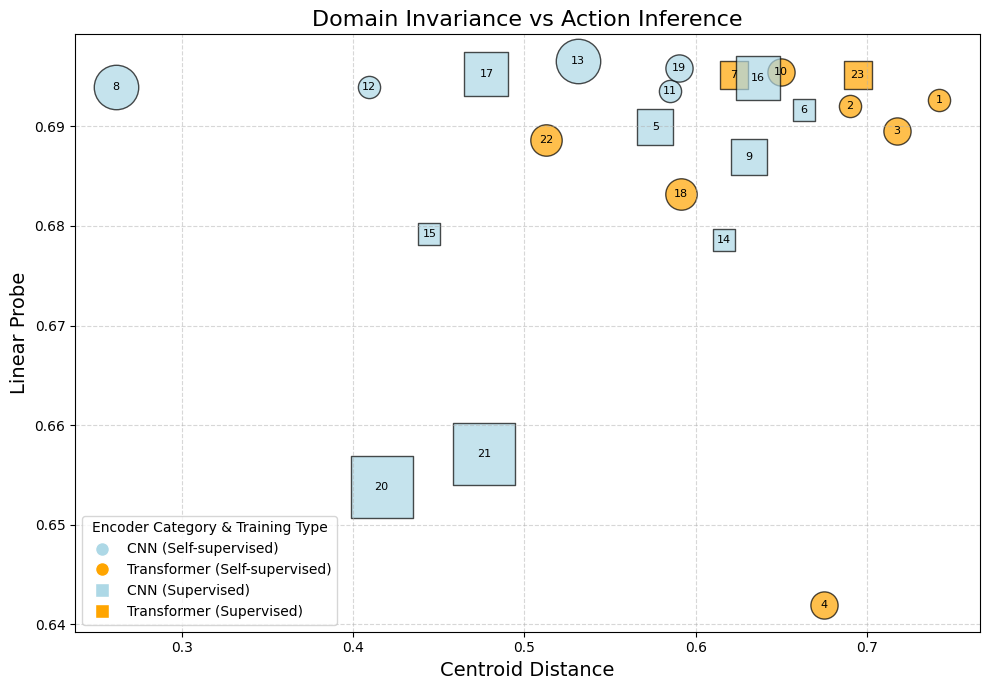

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Color map
from src.models.centroid_distance import centroid_distance
import re

# Function to find the linear probe result for an encoder
def find_probe_result(encoder):
    with open("/home/ubuntu/semrep/src/models/averages.txt", "r") as file:
        content = file.readlines()
    for line in content:
        if encoder in line:
            found_numbers = re.findall(r"\d+\.\d+", line)
            if found_numbers:
                return float(found_numbers[0])
    return None 

# Update encoders dictionary to include training type
encoders = {
    "CLIP-Base-16": ("Transformer", "Self-supervised"),
    "CLIP-Base-32": ("Transformer", "Self-supervised"),
    "CLIP-Large-14": ("Transformer", "Self-supervised"),
    "DinoV2-B": ("Transformer", "Self-supervised"),
    "EfficientNetB0": ("CNN", "Supervised"),
    "HRP-ResNet18": ("CNN", "Supervised"),
    "HRP-ViT": ("Transformer", "Supervised"),
    "MCR": ("CNN", "Self-supervised"),
    "MobileNetv3": ("CNN", "Supervised"),
    "MVP": ("Transformer", "Self-supervised"),
    "R3M18": ("CNN", "Self-supervised"),
    "R3M34": ("CNN", "Self-supervised"),
    "R3M50": ("CNN", "Self-supervised"),
    "ResNet18": ("CNN", "Supervised"),
    "ResNet34": ("CNN", "Supervised"),
    "ResNet50": ("CNN", "Supervised"),
    "ResNet101": ("CNN", "Supervised"),
    "Swin": ("Transformer", "Self-supervised"),
    "VC1-B": ("CNN", "Self-supervised"),
    "vgg16": ("CNN", "Supervised"),
    "vgg19": ("CNN", "Supervised"),
    "VIP": ("Transformer", "Self-supervised"),
    "ViT": ("Transformer", "Supervised"),
}

category_colors = {
    "CNN": "lightblue",
    "Transformer": "orange",
}

training_types = {
    "Self-supervised": "o",  # Circle for Self-supervised
    "Supervised": "s",       # Square for Supervised
}

plt.figure(figsize=(10, 7))
colormap = cm.viridis  

indices = list(range(1, len(encoders) + 1))
data_points = []


for idx, (encoder, (category, training_type)) in enumerate(encoders.items(), start=1):
    file_path = f"/home/ubuntu/semrep/embeddings/encoders/{encoder}.npz"
    dataset = np.load(file_path)
    embeddings = dataset["embeddings"]
    print(idx)
    x = centroid_distance(encoder, "euclidean", "min_max", "PCA")
    y = 1 - find_probe_result(encoder)
    size = embeddings.shape[1] * 0.5
    
    data_points.append((x, y, idx, category, training_type))

    # Plot with different marker shapes based on training type
    plt.scatter(x, y, s=size, color=category_colors[category], edgecolor="k", alpha=0.7, marker=training_types[training_type])

for x, y, idx, _, _ in data_points:
    plt.text(x, y, str(idx), fontsize=8, ha="center", va="center", color="black")


font = {'family': 'sans-serif', 
        'color':  'black',
        'weight': 'normal',
        'size': 16, 
        }

plt.title("Domain Invariance vs Action Inference", fontdict=font)
plt.xlabel("Centroid Distance", fontsize=14)
plt.ylabel("Linear Probe", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

# Update the legend with marker styles for training types
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors["CNN"], markersize=10, label='CNN (Self-supervised)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors["Transformer"], markersize=10, label='Transformer (Self-supervised)'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=category_colors["CNN"], markersize=10, label='CNN (Supervised)'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=category_colors["Transformer"], markersize=10, label='Transformer (Supervised)'),
]
plt.legend(handles=legend_elements, loc="lower left", title="Encoder Category & Training Type", fontsize=10)

plt.tight_layout()
plt.show()


In [8]:
model = models['ResNet34']()
print(model.model.layer4[-1])

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_block): Identity()
  (act1): ReLU(inplace=True)
  (aa): Identity()
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
)


In [12]:
model = models['CLIP-Base-16']()
print(model)

CLIPEncoder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizabl